In [1]:
import scanpy as sc
import cellrank as cr
from cellrank.kernels import RealTimeKernel
from moscot.problems.time import TemporalProblem
import pandas as pd
import numpy as np
import os

# 设置最大线程数

os.environ["OMP_NUM_THREADS"] = "40"
os.environ["OPENBLAS_NUM_THREADS"] = "40"
os.environ["MKL_NUM_THREADS"] = "40"
os.environ["VECLIB_MAXIMUM_THREADS"] = "40"
os.environ["NUMEXPR_NUM_THREADS"] = "40"


In [3]:
adata = sc.read_h5ad('/data/jiangjunyao/AEGAS_data/fate/Larry2020.h5ad')
adata.obs['day'] = 2
adata.obs.loc[adata.obs['celltype'] == 'undiff', 'day'] = 1

In [5]:
adata.obs['day'].value_counts()

day
1    3394
2    1998
Name: count, dtype: int64

In [6]:
adata.obs['celltype'].value_counts()

celltype
undiff        3394
Neutrophil    1104
Monocyte       894
Name: count, dtype: int64

In [7]:
tp = TemporalProblem(adata)
tp = tp.prepare(time_key="day")
tp = tp.solve()
tmk = RealTimeKernel.from_moscot(tp)
tmk.compute_transition_matrix(self_transitions="all", conn_weight=0.2, threshold="auto")
g = cr.estimators.GPCCA(tmk)

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(3394, 1998)].                                  


WARNING  Solver did not converge                                                                                   


100%|██████████| 1/1 [00:00<00:00, 12671.61time pair/s]


In [8]:
g.fit(cluster_key="celltype", n_states=2)

GPCCA[kernel=RealTimeKernel[n=5392], initial_states=None, terminal_states=None]

/data/jiangjunyao/miniconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/data/jiangjunyao/miniconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/data/jiangjunyao/miniconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/utils.py:1396: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/data/jiangjunyao/miniconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/utils.py:1397: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


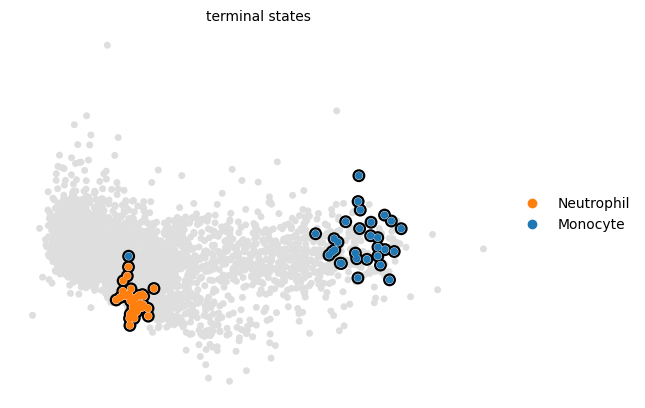

Defaulting to `'gmres'` solver.


100%|██████████| 2/2 [00:00<00:00,  9.62/s]


In [10]:
g.set_terminal_states(states=["Neutrophil", "Monocyte"])
g.plot_macrostates(which="terminal", legend_loc="right", size=100)
g.compute_fate_probabilities()

In [11]:
df1=pd.DataFrame(g.adata.obsm['lineages_fwd'],columns=['Neutrophil','Monocyte'])

In [15]:
from sklearn.metrics import accuracy_score, recall_score, f1_score
max_columns = df1.idxmax(axis=1)
adata.obs['pred'] = max_columns.tolist()
adata_final = adata[adata.obs.celltype=='undiff']
y_pred = adata_final.obs['pred']
y_true = adata_final.obs['lineage']

# 计算准确性

accuracy = accuracy_score(y_true, y_pred)

# 计算召回率

recall = recall_score(y_true, y_pred, average='macro')  # 根据需要选择合适的average参数

# 计算F1分数

f1 = f1_score(y_true, y_pred, average='macro')  # 根据需要选择合适的average参数

# 输出结果

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.6788450206246317
Recall: 0.6754276243839354
F1 Score: 0.6744579373460049


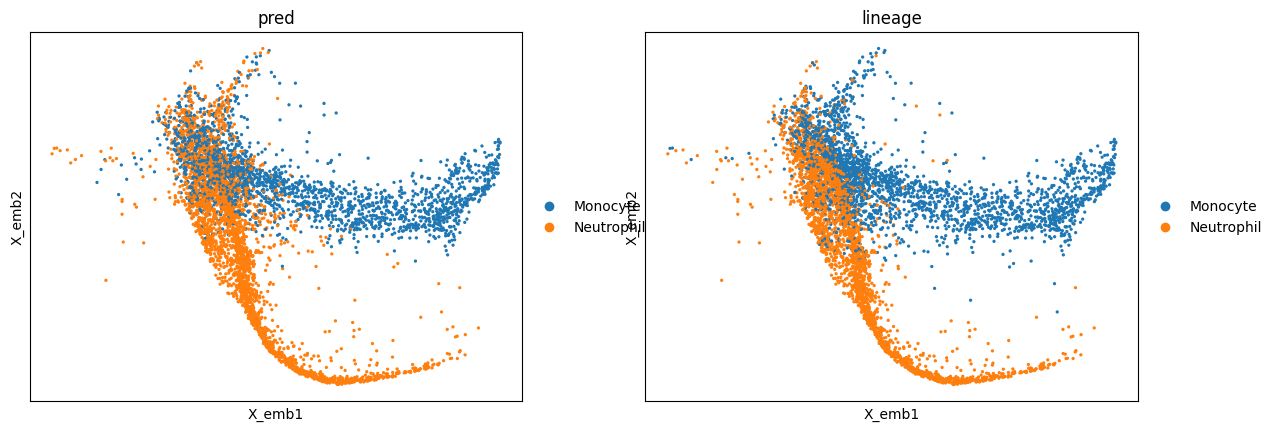

In [19]:
sc.pl.embedding(adata,color=['pred','lineage'],basis='X_emb')